In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os

# 데이터 로드

In [3]:
# 데이터 로드 및 변환
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR100(root="./data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 169M/169M [00:08<00:00, 20.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


# GAN

In [4]:
# GAN Generator
class GANGenerator(nn.Module):
    def __init__(self, nz, nc, hidden_dim):
        super(GANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(nz, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, nc * 32 * 32),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), -1)  # (batch_size, nz)
        return self.model(z).view(-1, 3, 32, 32)

# GAN Discriminator
class GANDiscriminator(nn.Module):
    def __init__(self, nc, hidden_dim):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(nc * 32 * 32, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.shape[0], -1)
        return self.model(img)


vanila GAN은 기본적으로 linear로 이루어져 있다.

따라서 linear를 쌓아 Generator와 Discriminator를 구성하였다.

# CGAN

In [5]:
# CGAN Generator
class CGANGenerator(nn.Module):
    def __init__(self, nz, nc, hidden_dim, num_classes):
        super(CGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)

        self.model = nn.Sequential(
            nn.Linear(nz + nz, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, nc * 32 * 32),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        z = torch.cat((z, label_emb), dim=1)  # concat
        return self.model(z).view(-1, 3, 32, 32)

# CGAN Discriminator
class CGANDiscriminator(nn.Module):
    def __init__(self, nc, hidden_dim, num_classes):
        super(CGANDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nc * 32 * 32)

        self.model = nn.Sequential(
            nn.Linear(nc * 32 * 32 + nc * 32 * 32, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img = img.view(img.shape[0], -1)
        label_emb = self.label_emb(labels)
        img = torch.cat((img, label_emb), dim=1)
        return self.model(img)


CGAN은 GAN에 condition을 추가한 모델이다.

Generator와 Discriminator에 condition을 입력으로 제공하여, 그 condition에 맞는 이미지를 생성하거나 판별하도록 한다. 따라서 class label을 condition으로 주어 특정 클래스에 해당하는 이미지를 생성할 수 있다.

condition을 입력을 주기 위해 보통 두 가지 방법을 사용한다.
* one-hot encoding
  - 단순하고 직관적이다.
  - 클래스 수가 많을수록 차원이 커져 메모리 사용이 비효율적이고 계산 비용이 높다.
  - 클래스 간의 관계나 유사성이 전혀 반영되지 않고 각 클래스는 독립적인 차원으로 표현된다.
  - 모델이 각 클래스에 대해 개별적으로 학습해야 하므로 학습 속도가 느릴 수 있다.
  - condition 간의 관계를 반영하지 않아 생성된 이미지가 제한적이고 단조로울 수 있다.
* embedding
  - 낮은 차원의 밀집 벡터로 데이터를 표현하여 메모리 사용과 계산 효율을 높인다.
  - 비슷한 클래스들이 임베딩 벡터 공간에서 가까운 위치에 배치되어 클래스 간 관계를 학습할 수 있다.
  - 연속적인 값으로 학습되며, 모델이 빠르고 효율적으로 학습한다. 정보가 더 밀집된 형태로 제공된다.
  - condition간 관계를 반영하여 다양한 조건에 맞는 이미지 생성이 가능하고, 더 자연스럽고 다채로운 결과를 제공한다.

이러한 특징들이 있다. 따라서 embedding이 더 좋다고 판단하여 embedding을 사용하여 condition을 입력해주었다.


In [6]:
# 학습 루프
nz = 100
nc = 3
hidden_dim = 256
num_classes = 100

gan_gen = GANGenerator(nz, nc, hidden_dim).cuda()
gan_disc = GANDiscriminator(nc, hidden_dim).cuda()
cgan_gen = CGANGenerator(nz, nc, hidden_dim, num_classes).cuda()
cgan_disc = CGANDiscriminator(nc, hidden_dim, num_classes).cuda()

criterion = nn.BCELoss()
gan_optimizer_g = optim.Adam(gan_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
gan_optimizer_d = optim.Adam(gan_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
cgan_optimizer_g = optim.Adam(cgan_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
cgan_optimizer_d = optim.Adam(cgan_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50

def train_gan(generator, discriminator, optimizer_g, optimizer_d, is_cgan=False):
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.cuda(), labels.cuda()
            batch_size = imgs.shape[0]
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            # 판별자 학습
            optimizer_d.zero_grad()
            if is_cgan:
                outputs = discriminator(imgs, labels)
            else:
                outputs = discriminator(imgs)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, nz).cuda()
            if is_cgan:
                fake_imgs = generator(z, labels)
            else:
                fake_imgs = generator(z)
            if is_cgan:
                outputs = discriminator(fake_imgs.detach(), labels)
            else:
                outputs = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # 생성자 학습
            optimizer_g.zero_grad()
            if is_cgan:
                outputs = discriminator(fake_imgs, labels)
            else:
                outputs = discriminator(fake_imgs)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    torch.save(generator.state_dict(), f"generator_{'cgan' if is_cgan else 'gan'}.pth")
    print(f"Training {'CGAN' if is_cgan else 'GAN'} Completed")



In [7]:
train_gan(gan_gen, gan_disc, gan_optimizer_g, gan_optimizer_d, is_cgan=False)

Epoch [1/50] Loss D: 0.3587, Loss G: 5.0993
Epoch [2/50] Loss D: 0.1971, Loss G: 5.0266
Epoch [3/50] Loss D: 0.1534, Loss G: 6.4570
Epoch [4/50] Loss D: 0.0919, Loss G: 4.7789
Epoch [5/50] Loss D: 0.0257, Loss G: 6.1913
Epoch [6/50] Loss D: 0.0554, Loss G: 7.4805
Epoch [7/50] Loss D: 0.2642, Loss G: 3.2188
Epoch [8/50] Loss D: 0.4229, Loss G: 6.5850
Epoch [9/50] Loss D: 0.4426, Loss G: 4.8232
Epoch [10/50] Loss D: 0.5360, Loss G: 4.3437
Epoch [11/50] Loss D: 0.5917, Loss G: 3.2311
Epoch [12/50] Loss D: 0.4558, Loss G: 3.1851
Epoch [13/50] Loss D: 0.6373, Loss G: 2.0738
Epoch [14/50] Loss D: 0.9189, Loss G: 2.2456
Epoch [15/50] Loss D: 0.8292, Loss G: 2.1722
Epoch [16/50] Loss D: 0.8782, Loss G: 2.2164
Epoch [17/50] Loss D: 0.6933, Loss G: 2.3633
Epoch [18/50] Loss D: 0.7284, Loss G: 2.5856
Epoch [19/50] Loss D: 0.9177, Loss G: 1.6233
Epoch [20/50] Loss D: 1.1496, Loss G: 1.7690
Epoch [21/50] Loss D: 0.6627, Loss G: 2.2435
Epoch [22/50] Loss D: 0.9653, Loss G: 2.3807
Epoch [23/50] Loss 

In [8]:
train_gan(cgan_gen, cgan_disc, cgan_optimizer_g, cgan_optimizer_d, is_cgan=True)

Epoch [1/50] Loss D: 0.5027, Loss G: 2.9158
Epoch [2/50] Loss D: 0.7746, Loss G: 2.3854
Epoch [3/50] Loss D: 0.4353, Loss G: 4.7669
Epoch [4/50] Loss D: 0.6501, Loss G: 2.3262
Epoch [5/50] Loss D: 0.7302, Loss G: 2.3314
Epoch [6/50] Loss D: 0.8383, Loss G: 2.0520
Epoch [7/50] Loss D: 1.1541, Loss G: 1.3971
Epoch [8/50] Loss D: 1.1359, Loss G: 1.4573
Epoch [9/50] Loss D: 0.9410, Loss G: 1.8388
Epoch [10/50] Loss D: 0.9494, Loss G: 1.6376
Epoch [11/50] Loss D: 1.0656, Loss G: 1.4225
Epoch [12/50] Loss D: 1.2791, Loss G: 1.2966
Epoch [13/50] Loss D: 1.4199, Loss G: 1.4884
Epoch [14/50] Loss D: 1.2379, Loss G: 1.5804
Epoch [15/50] Loss D: 0.9995, Loss G: 1.4114
Epoch [16/50] Loss D: 1.2491, Loss G: 1.2698
Epoch [17/50] Loss D: 1.3032, Loss G: 1.2371
Epoch [18/50] Loss D: 1.1751, Loss G: 1.4598
Epoch [19/50] Loss D: 1.1554, Loss G: 1.3547
Epoch [20/50] Loss D: 1.1879, Loss G: 1.3172
Epoch [21/50] Loss D: 1.1942, Loss G: 1.2770
Epoch [22/50] Loss D: 1.3871, Loss G: 1.3854
Epoch [23/50] Loss 

In [13]:
# 생성된 이미지 저장 경로
gan_output_dir = "./generated_images_gan"
cgan_output_dir = "./generated_images_cgan"
os.makedirs(gan_output_dir, exist_ok=True)
os.makedirs(cgan_output_dir, exist_ok=True)

def save_gan_images(generator, num_images, output_dir):
    generator.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, nz).cuda()
            fake_img = generator(z).cpu()

            vutils.save_image(fake_img, f"{output_dir}/gan_img_{i}.png", normalize=True)

def save_cgan_images(generator, num_images, output_dir, labels=None):
    generator.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, nz).cuda()  # Latent vector

            # 특정 클래스 리스트가 있으면 해당 클래스를 사용, 없으면 랜덤 클래스 선택
            if labels is not None:
                label = torch.tensor([labels[i % len(labels)]]).cuda()  # 리스트에서 순차적으로 선택
            else:
                label = torch.randint(0, num_classes, (1,)).cuda()  # 랜덤 클래스

            fake_img = generator(z, label).cpu()

            vutils.save_image(fake_img, f"{output_dir}/cgan_img_{i}_class_{label.item()}.png", normalize=True)



# 이미지 저장
save_gan_images(gan_gen, 20, gan_output_dir)
# CGAN: 특정 클래스 지정
save_cgan_images(cgan_gen, 20, cgan_output_dir, labels=[0])



GAN Generated Images:


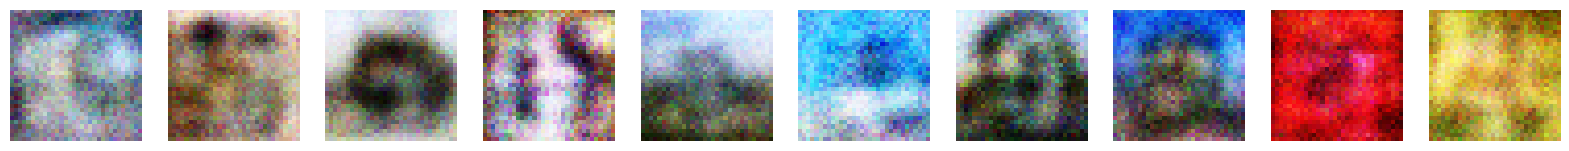

CGAN Generated Images:


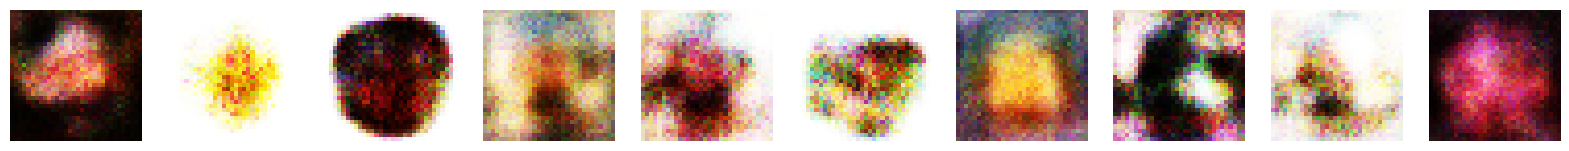

In [14]:
def visualize_generated_images(output_dir, num_images=10):
    image_paths = sorted(glob(f"{output_dir}/*.png"))[:num_images]  # 이미지 경로 가져오기
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # 가로로 출력

    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")  # 축 숨기기

    plt.show()

# GAN 이미지 시각화
print("GAN Generated Images:")
visualize_generated_images(gan_output_dir, num_images=10)

# CGAN 이미지 시각화
print("CGAN Generated Images:")
visualize_generated_images(cgan_output_dir, num_images=10)

# 결과 분석

GAN과 CGAN을 linear로 구성하였기 때문에 linear의 한계로 이미지가 알아볼 수 있을만큼 생성되지는 않았다.

GAN과 CGAN이 생성한 이미지들을 비교해보면 GAN의 경우 condition을 줄 수 없어 무작위로 이미지가 생성된 것을 볼 수 있다. 하지만 CGAN은 condition을 label=0 (apple)을 입력했기 때문에 이미지가 apple과 같은 형태로 생성된 것을 볼 수 있다.